In [1]:
import os
from random import shuffle
import json
from itertools import product, combinations
from time import perf_counter

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
import seaborn as sns

from src.models.monuseg.models import get_model
from src.data.monuseg.tf_data import get_dataset, tf_random_crop
from src.models.loss import dice_coe_loss, dice_coe_metric
from src.models.monuseg.evaluation import post_processing, post_processing_new
from src.models.monuseg.metrics import confusion_indices
from src.models.monuseg.train_model import eval

os.environ["CUDA_VISIBLE_DEVICES"] = "2"

path_indices = "/home/valentin/python_wkspce/2d_bispectrum_cnn/data/indices/monuseg.json"
split = 0

In [2]:
w_fg = 1.9
w_border = 5.0
w_bg = 0.44


def loss(y_true, y_pred):
    l = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    w = (y_true[..., 0] * w_fg + y_true[..., 1] * w_border +
         y_true[..., 2] * w_bg)
    return tf.reduce_mean(w * l, axis=(1, 2))

In [3]:
with open(path_indices, "r") as f:
    indices_list = json.load(f)

ds_train = get_dataset(id_list=indices_list[split]["train"]).take(1)
ds_train = ds_train.cache().repeat(15)
f1 = lambda image, seg: tf_random_crop(
    image, seg, rotation_angle="right-angle")
f2 = lambda image, seg: (
    tf.image.random_brightness(image, max_delta=0.2),
    seg,
)
ds_train = ds_train.map(f1).map(f2).batch(4)

ds_val = get_dataset(id_list=indices_list[split]["val"])
ds_val = ds_val.cache().batch(1)

ds_val_instance = get_dataset(id_list=indices_list[split]["val"],
                              instance=True)
ds_val_instance = ds_val_instance.cache().batch(1)

ds_test = get_dataset(id_list=indices_list[split]["test"], instance=True)
ds_test = ds_test.cache().batch(1)

In [4]:
model = get_model(
    model_name="BispectUnet",
    output_channels=3,
    n_harmonics=8,
    n_feature_maps=[8, 16, 32],
    radial_profile_type="disks",
)

In [5]:
model.load_weights(
    f"/home/valentin/python_wkspce/2d_bispectrum_cnn/models/MoNuSeg/"
    f"BispectUnet__rotation_True__nh_8__n_train_-1__psize_60x60__20211202-173734"
    f"/weights/split_{split}/final")


In [6]:
unet = get_model(
    # model_name="MaskedUnet",
    model_name="Unet",
    output_channels=3,
    n_feature_maps=[8, 16, 32],
)


In [7]:
unet.load_weights(
    f"/home/valentin/python_wkspce/2d_bispectrum_cnn/models/MoNuSeg/"
    f"Unet__rotation_True__nh_0__n_train_-1__psize_60x60__20211202-132039"
    f"/weights/split_{split}/final"
)

In [8]:
def random_crop(*args, size=(256, 256)):
    _, w, h, _ = args[0].shape
    origin_x = np.random.randint(0, high=w - size[0])
    origin_y = np.random.randint(0, high=h - size[1])
    outputs = list()
    for array in args:
        outputs.append(array[:, origin_x:origin_x + size[0],
                            origin_y:origin_y + size[1], :])
    return outputs

In [9]:
def colorize(y_pred):
    indices = np.unique(y_pred)
    indices = np.delete(indices, 0)
    output = np.zeros(y_pred.shape + (3, ))
    for i in indices:
        color = np.random.uniform(size=(3, ))
        positions = np.where(y_pred == i)
        output[positions[0], positions[1], :] = color
    return output

In [10]:
def confusion_indices_dev(y_true, y_pred):
    y_true_indices = np.unique(y_true)
    y_pred_indices = np.unique(y_pred)

    y_true_indices = np.delete(y_true_indices, y_true_indices == 0)
    y_pred_indices = np.delete(y_pred_indices, y_pred_indices == 0)

    matched_pred_indices = list()
    unmatched_true_indices = list()
    for i in y_true_indices:
        nuclei_mask = y_true == i
        y_pred_match = nuclei_mask * y_pred
        nuclei_area = np.sum(nuclei_mask)

        if np.sum(y_pred_match) == 0:
            unmatched_true_indices.append(i)
            continue
        else:
            pred_nuclei_indices = np.unique(y_pred_match)
            pred_nuclei_indices = np.delete(pred_nuclei_indices,
                                            pred_nuclei_indices == 0)
            matched = False
            for j in pred_nuclei_indices:
                if j not in matched_pred_indices:
                    if np.sum(y_pred_match == j) > 0.5 * nuclei_area:
                        matched_pred_indices.append(j)
                        matched = True
                        break

            if not matched:
                unmatched_true_indices.append(i)

    unmatched_pred_indices = list(
        set(y_pred_indices) - set(matched_pred_indices))
    return matched_pred_indices, unmatched_pred_indices, unmatched_true_indices

In [11]:
def fscore(tp, fp, fn):
    return tp / (tp + 0.5 * (fp + fn))

In [12]:
cropper = tf.keras.layers.Cropping2D((20, 20))

In [18]:
for x, y in ds_test.take(3).as_numpy_iterator():
    pass
x, y = random_crop(x,y)
y_c = cropper(y).numpy()[0, :, :, 0]

(matched_pred_bisp, unmatched_pred_bisp,
 unmatched_true_bisp) = confusion_indices_dev(y_c, post_processing(model(x)))
fp = len(unmatched_pred_bisp)
fn = len(unmatched_true_bisp)
tp = len(matched_pred_bisp)
print(f"fscore is {fscore(tp,fp,fn)}")

fscore is 0.8484848484848485


In [19]:
(matched_pred_unet, unmatched_pred_unet,
 unmatched_true_unet) = confusion_indices_dev(y_c, post_processing(unet(x)))
fp = len(unmatched_pred_unet)
fn = len(unmatched_true_unet)
tp = len(matched_pred_unet)
print(f"fscore is {fscore(tp,fp,fn)}")

fscore is 0.8484848484848485


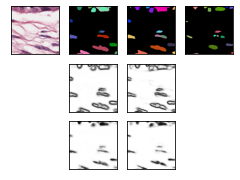

In [20]:
ncols = 3
nrows = 4
fig, axs = plt.subplots(ncols, nrows, figsize=(4, 3))
images = [
    cropper(x)[0, ...],
    colorize(post_processing(model(x))[0, ...]),
    colorize(post_processing(unet(x))[0, ...]),
    colorize(cropper(y)[0, :, :, 0]),
    None,
    model(x)[0, :, :, 1],
    unet(x)[0, :, :, 1],
    None,
    None,
    model(x)[0, :, :, 0],
    unet(x)[0, :, :, 0],
    None,
]
cmaps = [
    None, 'gray', 'gray', 'gray', None, "binary", "binary", None, None,
    "binary", "binary", None
]
for i, (r, c) in enumerate(product(range(ncols), range(nrows))):
    if images[i] is not None:
        pcm = axs[r, c].imshow(images[i], cmap=cmaps[i])
        axs[r, c].axes.xaxis.set_visible(False)
        axs[r, c].axes.yaxis.set_visible(False)
    else:
        axs[r, c].axis("off")
plt.savefig("comp_pred.png", dpi=200, bbox_inches='tight')

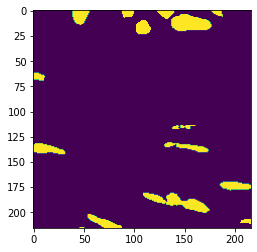

In [21]:
y_pred = model(x).numpy()
y_pred_quantized = (y_pred == y_pred.max(
    axis=-1,
    keepdims=True,
)).astype(int)
plt.imshow(y_pred_quantized[0,:,:,0])


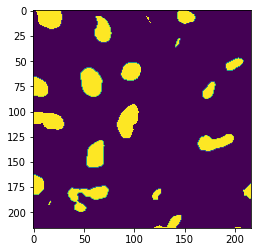

In [17]:
y_pred = unet(x).numpy()
y_pred_quantized = (y_pred == y_pred.max(
    axis=-1,
    keepdims=True,
)).astype(int)
plt.imshow(y_pred_quantized[0,:,:,0])
